In [1]:
from aide_design.play import*
from aide_design import floc_model as floc
from pytexit import py2tex

#Below are the items that were imported by the code above so that you know what abbreviations to use in your code.

# Third-party imports
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib

# AIDE imports
#import aide_design
#import aide_design.pipedatabase as pipe
#from aide_design.units import unit_registry as u
#from aide_design import physchem as pc
#import aide_design.expert_inputs as exp
#import aide_design.materials_database as mat
#import aide_design.utility as ut
#import aide_design.k_value_of_reductions_utility as k
#import aide_design.pipeline_utility as pipeline
#import warnings

# DC Stacked Rapid Sand Filtration

The stacked rapid sand filter at Tamara, Hondruas is treating 12 L/s of water with six 20 cm deep layers of sand. The sand has an effective size of 0.5 mm and a uniformity coefficient of 1.6. The backwash velocity of the filter is 11 mm/s. Defined below are many of the necessary inputs for the filtration analysis. 

In [2]:
flow_plant = 12 * u.L / u.s
density_sand = 2650 * u.kg / u.m**3
k_Kozeny = 5
H_filter_layer = 20 * u.cm
N_filter_layer = 6


#We will use 20 deg C as the typical operating temperature. Honduras is quite warm.
T_design = 20*u.degC


# Notes on Uniformity Coefficient and Effective size from http://www.clean-water-for-laymen.com/sand-sieve.html

#Effective Size (ES) – This is defined as the size of screen opening that will pass 10% of the sand sample (see more explanation below)
#Uniformity Coefficient (UC) – This is defined as a ratio and is calculated as the size opening that will just pass 60% of the sand (d60 value) divided by the size opening that will just pass 10% of the sand sample (d10 value).
#ES is basically a value describing the average size of sand grains in a sand sample.
#UC is basically a value describing the range of grain sizes present in a sample

D_filter_sand_ES = 0.5 * u.mm
UC_filter_sand = 1.6
porosity_filter_sand = 0.4
V_filter_backwash = 11 * u.mm / u.s
g = pc.gravity


<div class="alert alert-block alert-info">
## Remember: don't break continuity!

Ensure that you use the variables defined above in your code, do not hard code any numbers if you do not have to.

### 1)
Calculate the total sand depth of all 6 sand layers.

In [3]:
H_filter_sand_total = (H_filter_layer * N_filter_layer).to(u.m)

print('The total depth of the filter sand is', H_filter_sand_total)

The total depth of the filter sand is 1.2 meter


### 2)
Calculate the diameter that is larger than 60% of the sand (D60 of the filter sand).

In [4]:
D60_filter_sand = D_filter_sand_ES * UC_filter_sand

print('The D60 for the sand grain size is', D60_filter_sand)

The D60 for the sand grain size is 0.8 millimeter


### 3)
What is the total filter bed plan view area for both filters in Tamara?

In [5]:
A_filter_total = (flow_plant / V_filter_backwash).to(u.m**2)
print('The filter bed plan view area is ',A_filter_total)

The filter bed plan view area is  1.091 meter ** 2


### 4)
What is the velocity of water through a filter during filtration? Recall that the flow through the filter is the same in filter and backwash modes.

In [6]:
V_filter = V_filter_backwash / N_filter_layer

print('The filtration velocity is', V_filter)

The filtration velocity is 1.833 millimeter / second


### 5)
**Create a function** to calculate the head loss through the filter at the beginning of filtration with a clean filter bed. Then use that function to find the head loss through the clean bed of the Tamara filter. Assume that each flow path receives the same flow.

Recall:
 - If you have flow paths in parallel, the headloss is NOT the sum of the head loss in each path.
 - Instead, the head loss in each path is the same as the total head loss.


In [7]:
def headloss_kozeny(PorosityFilterSand, D60_filter_sand, VelocityFilter, DepthFilter):
   
    return (36*k_Kozeny*((1 - PorosityFilterSand)**2 / PorosityFilterSand**3) * (
            pc.viscosity_kinematic(T_design) * VelocityFilter)/(g * D_filter_sand_ES**2)* DepthFilter).to(u.cm)

hl_filter_clean = headloss_kozeny(porosity_filter_sand, D60_filter_sand, V_filter, H_filter_layer)
print('The headloss through the clean filter sand is', ut.sig(hl_filter_clean, 4))

The headloss through the clean filter sand is 15.20 cm


### 6)
**Create a function** to estimate the minimum fluidization velocity for this filter bed. Then use that function to find the minimum fluidization velocity of the Tamara filter. Fluidization occurs at the beginning of backwash as all of the water flows through the bottom inlet. Note that this is not the actual velocity used for backwashing the sand.

In [8]:
def velocity_backwash_min(porosity_sand, D60_filter_sand,T):
    return ((porosity_sand**3 * g * D60_filter_sand**2) / (
            36 * k_Kozeny * pc.viscosity_kinematic(T) * (1 - porosity_sand)) * (
            density_sand / pc.density_water(T)-1)).to(u.mm/u.s)

print('The minimum fluidization velocity for this filter bed is', ut.sig(velocity_backwash_min(porosity_filter_sand, D60_filter_sand,T_design),2))

The minimum fluidization velocity for this filter bed is 6.1 mm/s


### 7)
First, plot the minimum backwash velocity as a function of water temperature from 0°C to 30°C. Then use your plot to answer the following question: if you have a water treatment plant with a single filter and there is a drought that is reducing flow to the plant, when should you backwash the filter? Double click this cell and bold the correct answer. Recall that bolding is done by placing \** around the words you wish to bold.

1. **At the time of the day when the water is coolest**
1. At the time of the day when the water is warmest

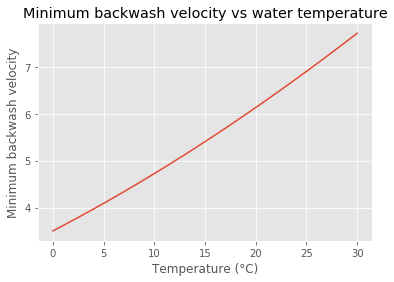

In [9]:
T_graph=np.linspace(0,30,50)*u.degC

ypoints = velocity_backwash_min(porosity_filter_sand, D60_filter_sand,T_graph)
plt.plot(T_graph,ypoints,'-')

plt.xlabel(r'Temperature (°C)')
plt.ylabel('Minimum backwash velocity')
plt.title('Minimum backwash velocity vs water temperature')
plt.show() 



### 8)
What is the residence time of water in the filter during backwash, when the bed is fluidized? You may assume the sand bed expansion ratio is 1.3.

In [10]:
Pi_filter_backwash_expansion = 1.3
t_res_filter_backwash = ((porosity_filter_sand * H_filter_sand_total + (
                            Pi_filter_backwash_expansion - 1) * H_filter_sand_total
                           ) / V_filter_backwash).to(u.s)


print('The residence time in the fluidized bed during backwash is', t_res_filter_backwash)

The residence time in the fluidized bed during backwash is 76.36 second


Our next overall goal is to determine the ratio of water wasted in a Stacked Rapid Sand Filter (SRSF) to water treated in a SRSF. Given that the backwash water that ends up above the filter bed never returns to the filter it isn't necessary to completely clear the water above the filter bed during a backwash cycle. Therefore we anticipate that backwash can be ended after approximately 3 expanded bed residence times. In addition it takes about 1 minute to initiate backwash by lowering the water level above the filter bed. 

### 9)

To start, estimate the time between beginning backwash and finishing the cleaning of the bed.

In [11]:
t_filter_backwash_drain = 1 * u.min
t_filter_backwash = (t_res_filter_backwash * 3 + t_filter_backwash_drain).to(u.s)

print('The time to backwash the filter is', t_filter_backwash)

The time to backwash the filter is 289.1 second


### 10)
Estimate the total **depth** of water that is wasted while backwash is occuring.

In [12]:
H_filter_backwash_water = (V_filter_backwash * t_filter_backwash).to(u.m)

print('The total depth of water that is wasted is', H_filter_backwash_water)

The total depth of water that is wasted is 3.18 meter


### 11)
Estimate the total depth of water that is lost due to refilling the filter box at the end of backwash plus the slow refilling to the maximum dirty bed height. You may ignore the influence of plumbing head loss and you may assume that the dirty bed head loss is about 40 cm. The water level in the filter during backwash is lower than the water level at the end of filtration by both the head loss during backwash AND the headloss at the end of filtration. There is also an additional 20 cm of lost water that is required for the hydraulic controls.

To reiterate, the three components that contribute to the depth of water lost in refilling the filter box after backwash are as follows:

1. Head loss during clean-bed filtration.
1. Difference in head loss between clean-bed filtration and dirty-bed filtration, just before backwash.
1. Height of the pipe that initiates backwash, also called the hydraulic control. This is actuall the pipe's diameter, since it is laying sideways in the fitler.

In [13]:
hl_filter_final = 40 * u.cm
H_hydraulic_controls = 20*u.cm
H_filter_backwash_water_refill = H_filter_sand_total + H_hydraulic_controls + hl_filter_final

print('The total depth of water that is lost due to refilling the filter box is', H_filter_backwash_water_refill)

The total depth of water that is lost due to refilling the filter box is 1.8 meter


### 12)
Now calculate the total length (or depth) of water that is wasted due to backwash by adding the two previous lengths. The lengthh found in problem 10 represents water wasted while backwash is occuring, while the length in problem 11 represents the water lost in the transition to and from backwash.

In [14]:
H_filter_backwash_water_wasted = H_filter_backwash_water + H_filter_backwash_water_refill
print('The depth of the water that is wasted due to backwash is', H_filter_backwash_water_wasted)

The depth of the water that is wasted due to backwash is 4.98 meter


### 13)
Assume that the filter is backwashed every 12 hours. This means that the filter is producing clean water for 12 hours before it need to be backwashed. What is the total height (or length) of water that would be treated by the filter during this time? This length when multiplied by the area of the filter would give the total volume of water processed by a filter.

In [15]:
t_filter_cycle = 12 * u.hr
H_water_filtered_per_cycle = (t_filter_cycle * V_filter_backwash).to(u.m)
print('The height of water that would enter the filter in 12 hours is', H_water_filtered_per_cycle)

The height of water that would enter the filter in 12 hours is 475.2 meter


### 14)
Finally, what is the ratio of water lost due to backwash and related water level changes in the filter box to water treated?

In [16]:
Pi_water_wasted = (H_filter_backwash_water_wasted / H_water_filtered_per_cycle)
print('The fraction of the total water that is lost due to backwash is', Pi_water_wasted)

The fraction of the total water that is lost due to backwash is 0.01048 dimensionless


# Extra analysis that * is already completed*
### 15:
Now we will evaluate the very first data set from a full scale SRSF. The performance data given below is the settled water turbidity and then the filtered water turbidity during one filter run. The time step is 5 minutes. Plot pC\* for the filter as well as effuent turbidity as a function of time on two separate graphs.

In [17]:
filter_influent = np.array([7.06201,7.14465,7.00537,6.33032,5.4502,4.98511,4.64221,4.23853,3.93707,3.72717,3.67126,3.55866,3.55292,3.45593,3.48163,3.50226,3.45093,3.50232,3.41095,3.55341,3.46643,3.50732,3.49146,3.51208,3.487,3.58893,3.54315,3.61469,3.58429,3.55835,3.72723,3.7829,3.74201,3.82398,3.74725,3.83423,3.72717,3.72705,3.87079,3.77338,3.70148,3.74762,3.76227,3.58875,3.63477,3.67566,3.52789,3.59296,3.66577,3.51709,3.63965,3.57843,3.47546,3.66016,3.58386,3.53259,3.57886,3.51392,3.63983,3.64972,3.64606,3.49121,3.51691,3.5119,3.61414,3.5835,3.46558,3.63965,3.60962,3.50147,3.51678,3.46039,3.49133,3.48566,3.50104,3.5943,3.47778,3.53766,3.55811,3.50635,3.42535,3.48077,3.54242,3.55274,3.59369,3.48596,3.53296,3.51746,3.45056,3.59387,3.5426,4.26868,3.99201,3.45569,3.86975,3.54407,3.49097,3.9823,3.58325,3.77789,3.70111,3.59839,4.09424,3.56769,3.83325,3.76019,3.49121,4.52917,3.63037,4.21228,3.60858,4.72827,4.00757,3.71674,3.87647,3.8288,3.44067,3.74219,3.64941,3.87439,3.79327,4.10486,4.16638,3.84418,4.11792,3.46082,3.71661,3.5061,3.48596,4.42175,3.57806,4.01294,3.63965,3.80408,3.60431,3.67572,3.61981,3.66022,3.67554,3.46076,3.72669,3.56287,3.66003,3.60004,3.4812,3.55823,6.19641,3.74146,3.88025,4.18713,4.27881,3.6496,3.45111,3.8656,3.90106,3.68597,3.66101,3.88513,3.74652,3.70123,3.79828,3.84369,3.59418,3.60968,3.49127,3.45081,3.40424,3.35852,3.32788,3.29211,3.21008,3.79279,])*u.NTU
filter_effluent = np.array([0.926376,0.645981,0.69725,0.625855,0.600449,0.472694,0.381546,0.340439,0.309883,0.289848,0.27813,0.254097,0.249432,0.253769,0.203117,0.253891,0.34063,0.223385,0.365952,0.264389,0.259193,0.340576,0.279671,0.309776,0.304878,0.279404,0.299896,0.340294,0.25399,0.350731,0.34053,0.487877,0.391518,0.309715,0.360901,0.442352,0.30967,0.391251,0.457253,0.447685,0.386322,0.549149,0.33036,0.426437,0.513458,0.279022,0.462692,0.589768,0.381073,0.532669,0.538529,0.350472,0.559036,0.51828,0.462578,0.594772,0.47242,0.538681,0.605087,0.402168,0.538818,0.66658,0.447243,0.574585,0.691544,0.513382,0.655701,0.655884,0.605408,0.666153,0.599976,0.651047,0.702515,0.92572,0.90535,0.732117,0.605026,0.849335,0.691925,0.584976,0.803314,0.783569,0.706787,0.783066,0.640701,0.732269,0.803497,0.625458,0.625687,1.00089,1.03265,1.00687,0.834213,0.732224,0.859665,0.559174,1.08862,0.93634,0.722717,0.966141,1.03278,0.890366,0.874756,0.813675,0.864746,0.874863,0.625504,0.874847,0.889893,0.931473,0.880112,1.30231,0.813965,0.961502,0.966324,0.839432,0.889969,0.930618,1.20074,0.93631,0.951584,0.78331,0.961609,0.996796,0.940994,0.966675,1.04788,0.951645,0.966888,1.01251,0.96167,1.0076,0.900436,0.996628,1.12949,0.910263,1.03256,1.04788,0.997604,1.05817,1.05801,1.06311,1.05805,1.00711,1.05811,1.11896,1.06299,1.07318,0.966049,1.07343,1.09918,1.15497,1.07303,1.13937,1.12402,1.155,1.15436,1.2056,1.14954,1.17526,1.15457,1.20569,1.17517,1.0376,0.915253,0.935471,0.884979,0.89035,0.940781,0.885071,0.874817,0.828796])*u.NTU

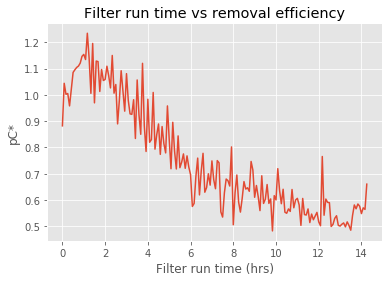

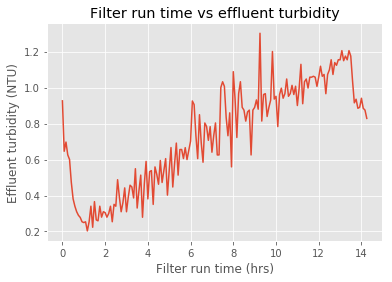

In [18]:
t_delta = 5 * u.min
t_end = np.shape(filter_effluent)[0]
t_data = np.arange(0,t_end)*t_delta
c_dim = np.divide(filter_effluent,filter_influent)
filter_pc = -np.log10(c_dim)

plt.plot(t_data.to(u.hour),filter_pc)
plt.xlabel('Filter run time (hrs)')
plt.ylabel('pC*')
plt.title('Filter run time vs removal efficiency')
plt.grid(True)

plt.show()


plt.plot(t_data.to(u.hour),filter_effluent)
plt.xlabel('Filter run time (hrs)')
plt.ylabel('Effluent turbidity (NTU)')
plt.title('Filter run time vs effluent turbidity')
plt.grid(True)

plt.show()


The filter performance deteriorated over the length of the filter run. This does not match the expectations that we have based on laboratory experiments with filters. AguaClara has limited data of filter performance as a function of time. However, the [recent data from Tamara](http://aguaclara.github.io/index.html) (select Tamara from the drop down menu of plants) suggests that filtered water turbidity is consistently lower than in this first run of the filter that you plotted above.

### 16)
How many kg of suspended solids per square meter of filter were removed during this filter run. Use the plan view area for the filter (don't multiply by the number of layers)

In [19]:
M_filter_solids = (np.sum((filter_influent - filter_effluent) * (
                    flow_plant * t_delta)/ A_filter_total)
                     ).to(u.kg/u.m**2)

print('The mass of the suspended solids removed is', ut.sig(M_filter_solids,3))

The mass of the suspended solids removed is 2.94 kg/m²


### 17)
Another useful way to express the solids capacity of the filter is to calculate the turbidty removed the run time and then express the results with units of NTU hrs. What was the capacity of the filter in NTU hrs?

In [20]:
solids_capacity_filter = (np.sum((filter_influent-filter_effluent) * t_delta)).to(u.NTU * u.hr)


print('The filter capacity is',solids_capacity_filter,)

The filter capacity is 43.72 NTU * hour


### 18)
How long was the filter run?

In [21]:
t_filter_cycle = t_data[np.size(t_data)-1]
print('The filter was run for', t_filter_cycle.to(u.hour))

The filter was run for 14.25 hour


### 19)
What is the total volume of pores per square meter (plan view area) of StarS filter bed (includes all 6 layers) (in L/m^2)?

In [22]:
volume_filter_pores = (H_filter_sand_total * porosity_filter_sand).to(u.L/u.m **2)
print('The total volume of pores is', volume_filter_pores)

The total volume of pores is 480 liter / meter ** 2


### 20)
The next step is to estimate the volume of flocs per plan view area of the filter. Assume the density of the flocs being captured by the filter are approximated by the density of flocs that have a sedimentation velocity of 0.10 mm/s (slightly less than the capture velocity of the plate settlers). (see slides in flocculation notes for size of the floc and then density of that floc. I've provided this value below to simplify the analysis

In [23]:
density_floc = pc.density_water(T_design) + 100 * u.kg/u.m**3
density_clay = 2650 * u.kg/u.m**3

Given the floc density, calculate fraction of floc volume that is clay.

Given that floc mass is the sum of clay mass and water mass and given that floc volume is the sum of clay volume and water volume, derive an equation for the volume of flocs per plan view area of a stacked rapid sand filter (includes all 6 layers) given the floc, clay, and water densities and the mass of the clay. Show the equations that you derive using Latex

Mass conservation gives
$$ Vol_{Floc} \cdot \rho_{Floc} = M_{Clay} + M_{Water} $$

$M_{Water}$ is an unknown. 
$$ M_{Water} = Vol_{Floc} \cdot \rho{Floc} - M_{Clay} $$

Volume conservation gives
$$ Vol_{Floc} = Vol_{Clay} + Vol_{Water} $$

$$ Vol_{Floc} = \frac{M_{Clay}}{\rho_{Clay}} + \frac{M_{Water}}{\rho_{Water}}  $$

Substitute to eliminate $M_{Water}$
$$ Vol_{Floc} = \frac{M_{Clay}}{\rho_{Clay}} + \frac{Vol_{Floc} \cdot \rho_{Floc}}{\rho_{Water}} -\frac{M_{Clay}}{\rho_{Water}} $$

Solve for $Vol_{Floc}$
$$ Vol_{Floc} - \frac{Vol_{Floc} \cdot \rho_{Floc}}{\rho_{Water}} = \frac{M_{Clay}}{\rho_{Clay}} - \frac{M_{Clay}}{\rho_{Water}} $$

$$ Vol_{Floc}\left ( 1-\frac{\rho_{Floc}}{\rho_{Water}} \right ) = M_{Clay}\left ( \frac{1}{\rho_{Clay}} -\frac{1}{\rho_{Water}}\right ) $$

$$ Vol_{Floc} = M_{Clay}\left ( \frac{\frac{1}{\rho_{Clay}}-\frac{1}{\rho_{Water}}}{ 1-\frac{\rho_{Floc}}{\rho_{Water}}} \right ) $$

$$ Vol_{Floc} = { \frac{M_{Clay}\rho_{Water}}{\rho_{Floc}-\rho_{Water}}}\left ( \frac{1}{\rho_{Water}}-\frac{1}{\rho_{Clay}} \right )$$

In [24]:
vol_floc = ((M_filter_solids *pc.density_water(T_design)/(density_floc-pc.density_water(T_design))) *  
            ((1/pc.density_water(T_design))-1/density_clay)).to(u.l / u.m **2)
print('The volume of the flocs per plan view area is', vol_floc)

The volume of the flocs per plan view area is 18.34 liter / meter ** 2


### 21)
What percent of the filter pore volume is occupied by the flocs? This fraction of pore space occupied is quite small and suggests that much of the filter bed has a very low particle concentration at the end of a filter run.

In [25]:
Pi_flocvolume_porevolume = (vol_floc / volume_filter_pores)

print('The fraction of filter pore volume that is occupied by flocs is', ut.sig(Pi_flocvolume_porevolume,3))    

The fraction of filter pore volume that is occupied by flocs is 0.0382


# Filter constriction hypothesis
The following analysis is completed for you and is intended to illustrate the hypothesis that flocs that are removed by the filter form a small diameter flow constriction at each place where the sand grains form a flow constriction.

Final head loss for the filter was 50cm. Assume that this is caused by minor losses due to creation of a floc orifice (constriction) in each pore. Find the minor loss contribution by subtracting the clean bed head loss to find the head loss created by the flow constrictions that were created by the flocs.

In [26]:
hl_filter_final = 50 * u.cm
hl_constriction = hl_filter_final-hl_filter_clean

print('The minor loss contribution is', hl_constriction)

The minor loss contribution is 34.8 centimeter


If we assume that at the end of the filter run every pore in the filter had a flow constricting orifice from the deposition of flocs in the pore, then what was the diameter of each of the flow constrictions? We will calculate this in several steps. To begin, estimate how many flow constrictions are created by the sand grains before any flocs are added with the assumption that there is one flow constriction per sand grain. How many sand grains are there per cubic meter of filter bed? Use D60_filter_sand to estimate the number of sand grains. We will assume there is a one to one correspondence between sand grains and flow constrictions.

In [27]:
vol_filter_sand_grain = D60_filter_sand**3 * np.pi/6

vol_filter_sand_grain_and_pore = vol_filter_sand_grain / (1 - porosity_filter_sand)

N_sand_grains = 1 /(vol_filter_sand_grain_and_pore)

print('There are this many sand grains in a cubic millimeter', N_sand_grains.to(1/u.mm**3)) 

There are this many sand grains in a cubic millimeter 2.238 / millimeter ** 3


Estimate the average vertical distance between flow constriction based on the cube root of the volume occupied by a sand grain

In [28]:
L_grain_separation = (vol_filter_sand_grain_and_pore **(1/3)).to(u.mm)

print('The distance between flow constriction is', L_grain_separation)

The distance between flow constriction is 0.7645 millimeter


On average, how many sand grain flow constriction does a water molecule flow through on its way through the filter?

In [29]:
N_constriction = (H_filter_layer/L_grain_separation).to(u.dimensionless)

print('A water molecule flows through', N_constriction,'constriction through the filter')

A water molecule flows through 261.6 dimensionless constriction through the filter


What is the head loss per flow constriction?

In [30]:
hl_per_constriction = (hl_constriction / N_constriction).to(u.mm)
print('The head loss per constriction is', hl_per_constriction)

The head loss per constriction is 1.33 millimeter


If each constriction was partially clogged with flocs at the end of the filter run, estimate the velocity in the constriction using the expansion head loss equation. You can use the average pore water velocity as a good estimate of the expanded flow velocity.
$$ h_{e} = \frac{(V_{in}-V_{out})^2}{2g} $$

In [31]:
V_pore = V_filter / porosity_filter_sand
V_constriction = ((2 * g * hl_per_constriction)**(1/2) + V_pore).to(u.mm /u.s)

print('The velocity in the constriction is', V_constriction)

The velocity in the constriction is 166.1 millimeter / second


What is flow rate of water through each pore in μL/s? You can estimate this from the number of pores per square meter given the average separation distance.


In [32]:
N_pore_per_area = 1 / L_grain_separation**2
flow_per_pore = (V_filter/ N_pore_per_area).to(u.microliter/u.s)

print('The flow rate through each pore is', flow_per_pore)

The flow rate through each pore is 1.071 microliter / second


What is the inner diameter of the flow constriction created by the flocs if the vena contracta is 0.62?

In [33]:
Pi_vena_contracta = 0.62
A_constriction = flow_per_pore / V_constriction/Pi_vena_contracta
D_constriction = pc.diam_circle(A_constriction)
print('The inner diameter of the flow constriction created by the flocs is', D_constriction.to(u.micrometer))

The inner diameter of the flow constriction created by the flocs is 115.1 micrometer


Plot the fractional removal per constriction as a function of particle size.

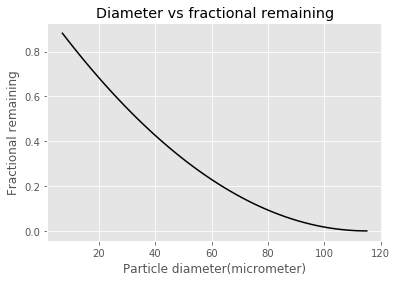

In [34]:
D_clay = 7 * u.micrometer 

#create an array of floc sizes from clay diameter up to the diameter of the constriction

def D_floc(D_constriction):
    return (np.linspace(D_clay.to(u.micrometer), D_constriction.to(u.micrometer)))*u.micrometer


#below is an estimate of the floc removal efficiency as a function of the floc size
def c_star_constriction(D_constriction):
    return ((D_constriction - D_floc(D_constriction))
            / D_constriction)**2
    
c_star = c_star_constriction(D_constriction)
plt.xlabel('Particle diameter(micrometer)')
plt.ylabel('Fractional remaining')
plt.title('Diameter vs fractional remaining')
plt.grid(True)

plt.plot(D_floc(D_constriction), c_star_constriction(D_constriction),'black' )
plt.show()

There are many constrictions in series and the filter fraction remaining is the pore fraction remaining raised to the power of the number of pores in series. 